## Notebook showing example of plotting demand against supply


In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [13]:
from pathlib import Path
import sys
import json


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work' / 'zella'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))


model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)

from viz.prob_dist_plot import prob_dist_plot
from plot_pipeline import create_colour_dict
spec_colour_dict = create_colour_dict()
figsize_global = (6,4)

In [14]:
import os
os.listdir()
sys.path

['/home/jovyan/work/zella/patientflow/notebooks',
 '/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/opt/conda/lib/python3.10/site-packages',
 '/home/jovyan/work/patientflow/src/patientflow',
 '/home/jovyan/work/patientflow/functions',
 '/home/jovyan/work/patientflow/src/patientflow',
 '/home/jovyan/work/patientflow/functions',
 '/home/jovyan/work/patientflow/src/patientflow',
 '/home/jovyan/work/patientflow/functions',
 '/home/jovyan/work/zella/patientflow/src/patientflow',
 '/home/jovyan/work/zella/patientflow/functions']


### Create fictional distributions

In [286]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.signal import convolve

# Parameters for the Poisson distributions
size = 50    # Size of the distributions

# Generate the Poisson distributions
x = np.arange(size)
poisson1 = poisson.pmf(x, 2) # in ED now
poisson2 = poisson.pmf(x, 3) # yta
poisson3 = poisson.pmf(x, 6) # discharges

# Create DataFrames for each Poisson distribution
ed = pd.DataFrame(data={'agg_proba': poisson1}, index=x)
yta = pd.DataFrame(data={'agg_proba': poisson2}, index=x)

# Function to compute the combined probabilities
def compute_combined_probabilities(df1, df2, add = True):
    combined_probs = {}
    for i in df1.index:
        # print(i)
        for j in df2.index:
            if add:
                new_index = i + j
            else:
                new_index = i - j
            prob = df1.loc[i, 'agg_proba'] * df2.loc[j, 'agg_proba']
            # print(j)
            # print(combined_probs)
            if new_index in combined_probs:
                combined_probs[new_index] += prob
            else:
                combined_probs[new_index] = prob
    
    return pd.DataFrame(list(combined_probs.items()), columns=['index', 'agg_proba']).set_index('index').sort_index()

# Compute the combined probabilities
demand = compute_combined_probabilities(ed, yta, add = True)

supply = pd.DataFrame(data={'agg_proba': poisson3}, index=x)
netposition = compute_combined_probabilities(supply, demand, add = False)



In [287]:
directory_path = media_file_path / 'supply_demand_examples'
directory_path.mkdir(parents=True, exist_ok=True)
directory_path

PosixPath('/home/jovyan/work/patientflow/notebooks/img/supply_demand_examples')

## Define functions

In [288]:
def index_of_sum(sequence: list[float], max_sum: float) -> int:
    s = 0.0
    for i, p in enumerate(sequence):
        s += p
        if s >= 1 - max_sum:  ## only this line has changed
            return i
    return i


In [293]:
from matplotlib import pyplot as plt
import numpy as np
import itertools
from ed_admissions_realtime_preds import index_of_sum


def prob_dist_plot(prob_dist_data, title_, directory_path = None, figsize = (6,3), include_titles = False, truncate_at_beds=None, text_size = None, bar_colour='#5B9BD5', file_name = None, 
                   plot_min_beds_lines = False, plot_bed_base = None, cdf_cut_points = [0.9, 0.1]):
            
    
    min_beds_lines = {}

    for cut_point in cdf_cut_points: 
        
        min_beds_lines[cut_point] = index_of_sum(prob_dist_data.values, cut_point)
        
    plt.figure(figsize=figsize)
    
    if not file_name:
        file_name = title_.replace(' ', '_').replace('/n', '_').replace('%', 'percent') + '.png'
    plt.bar(prob_dist_data.index, 
            prob_dist_data['agg_proba'],
            color=bar_colour)
    if truncate_at_beds:
        plt.xlim(-0.5, truncate_at_beds + 0.5)
    # plt.xticks(np.arange(0, truncate_at_beds + 1, 5))  # Set x-axis ticks at every 5 units

    if plot_min_beds_lines:

        colors = itertools.cycle(plt.cm.gray(np.linspace(0.3, 0.7, len(min_beds_lines))))
        
        for point in min_beds_lines:
            plt.axvline(x=prob_dist_data.index[min_beds_lines[point]], linestyle='--', linewidth=2, color=next(colors), label=f'{point*100:.0f}% probability')

        plt.legend(loc='upper right', fontsize = 14 )
        
    if plot_bed_base:
        
        colors = itertools.cycle(plt.cm.gray(np.linspace(0.3, 0.7, len(min_beds_lines))))

        for point in plot_bed_base:
            plt.axvline(x=plot_bed_base[point], linestyle='--', linewidth=2, color=next(colors), label=f'bed balance')
            
        plt.legend(loc='upper right', fontsize = 14 )
    
    if text_size:

        plt.tick_params(axis='both', which='major', labelsize=text_size)
        plt.xlabel('Number of beds', fontsize = text_size)

    plt.tight_layout()
    
    if directory_path:
        plt.savefig(directory_path / file_name.replace(' ','_'), dpi=300)
    plt.show()

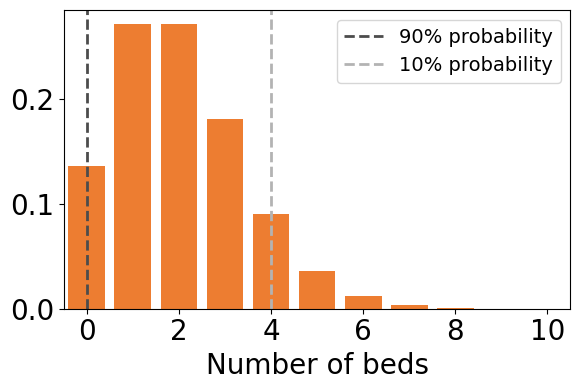

In [294]:
prob_dist_plot(prob_dist_data=ed.loc[0:10], title_='Patients in ED', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 10,

                  bar_colour = spec_colour_dict['single']['medical'] , plot_min_beds_lines = True)

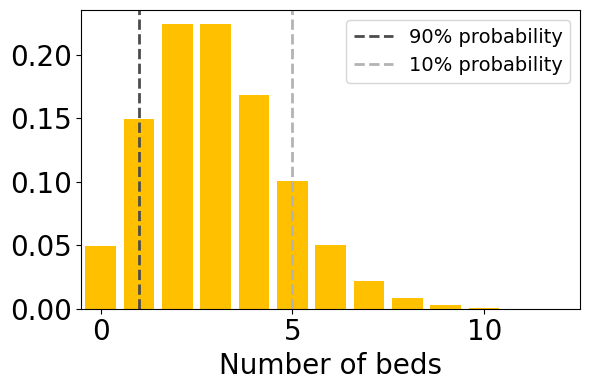

In [295]:

        
   
    
    prob_dist_plot(prob_dist_data=yta.loc[0:10], title_='Patients yet to arrive', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   truncate_at_beds = 12,
                  bar_colour = spec_colour_dict['single']['haem/onc'], plot_min_beds_lines = True)

<Figure size 600x300 with 0 Axes>

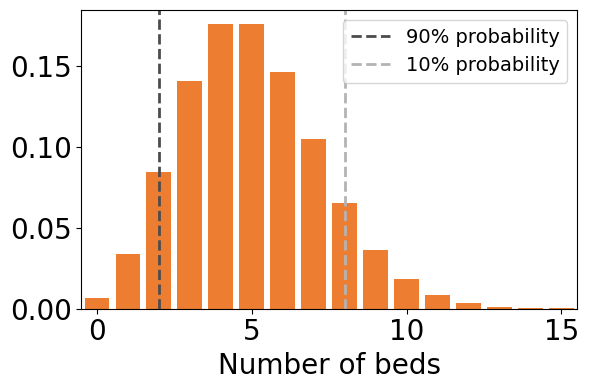

In [297]:
prob_dist_data = demand
plt.figure(figsize=(6,3))
truncate_at_ = 40

prob_dist_plot(prob_dist_data=demand.loc[0:15], title_='Total demand', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   truncate_at_beds = 15,
                  bar_colour = spec_colour_dict['single']['medical'] , plot_min_beds_lines = True)

In [280]:
def index_of_sum(sequence: list[float], max_sum: float) -> int:
    s = 0.0
    print(1 - max_sum)
    for i, p in enumerate(sequence):
        print(i, s)
        s += p
        if s >= 1 - max_sum:  ## only this line has changed
            return i
    return i

In [281]:
df_cut_points = [0.9, 0.1]
min_beds_lines = {}
prob_dist_data=supply
for cut_point in cdf_cut_points: 
    
    min_beds_lines[cut_point] = index_of_sum(prob_dist_data.values, cut_point)


0.09999999999999998
0 0.0
1 [0.00247875]
2 [0.01735127]
3 [0.0619688]
0.9
0 0.0
1 [0.00247875]
2 [0.01735127]
3 [0.0619688]
4 [0.15120388]
5 [0.2850565]
6 [0.44567964]
7 [0.60630278]
8 [0.74397976]
9 [0.84723749]


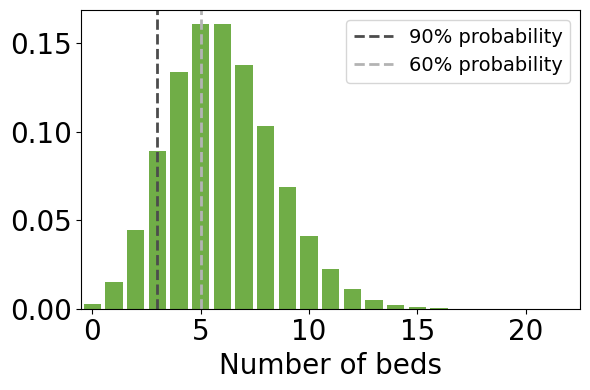

In [300]:
prob_dist_plot(prob_dist_data=supply.loc[0:22], title_='Discharges', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   truncate_at_beds = 22,
                  bar_colour = spec_colour_dict['single']['surgical'] , plot_min_beds_lines = True, cdf_cut_points = [0.9, 0.6])

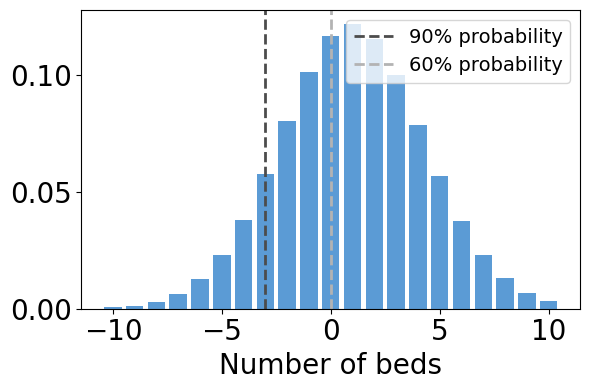

In [303]:


prob_dist_plot(prob_dist_data=netposition.sort_index().loc[-10:10], title_='Net position', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   # truncate_at_beds = 15,
                  bar_colour = spec_colour_dict['single']['paediatric'], plot_min_beds_lines = True, cdf_cut_points = [0.9, 0.6])

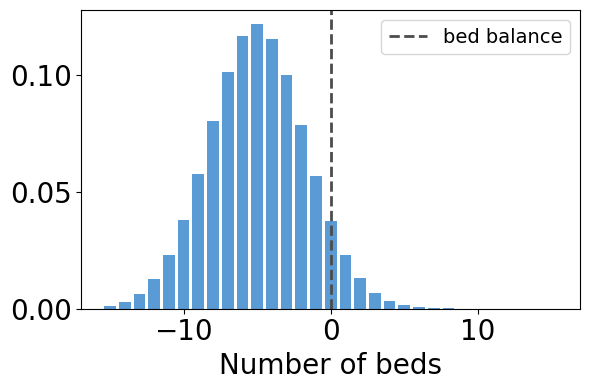

In [309]:
# Assuming bed base is 16
bedbase = netposition.copy(deep = True)
bedbase.index = bedbase.index + 16 -22

prob_dist_plot(prob_dist_data=bedbase.sort_index().loc[-15:15], title_='Bed base with line at zero', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   # truncate_at_beds = 15,
                              plot_bed_base = [0],
                  bar_colour = spec_colour_dict['single']['paediatric'], cdf_cut_points = [0.9, 0.6])


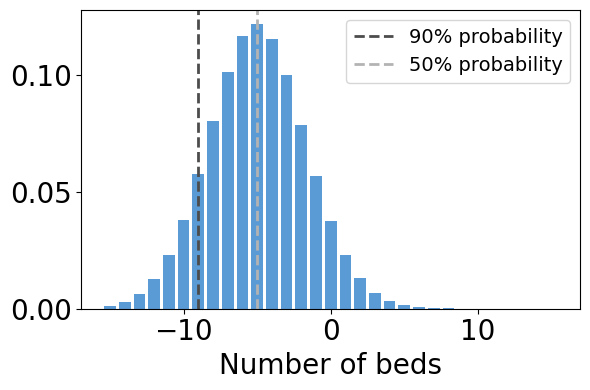

In [312]:
# Assuming bed base is 16
bedbase = netposition.copy(deep = True)
bedbase.index = bedbase.index + 16 -22

prob_dist_plot(prob_dist_data=bedbase.sort_index().loc[-15:15], title_='Bed base', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   # truncate_at_beds = 15,
                              # plot_bed_base = [0],
               plot_min_beds_lines = True, 
                  bar_colour = spec_colour_dict['single']['paediatric'], cdf_cut_points = [0.9, 0.5])
